In [2]:
import torch
torch.manual_seed(0)
from data import create_joint_x_y
from optimal_transport import estimate_U_from_phi
from picnn import SCPICNN

dataset_size = 1000
X, Y = create_joint_x_y(dataset_size)

n, d = Y.shape
m = n

phi_network = SCPICNN(
    alpha=0.01,
    x_dimension=X.shape[1],
    y_dimension=d,
    u_dimension=100,
    z_dimension=100,
    output_dimension=1,
    number_of_hidden_layers=4
)

device_and_dtype_specifications = dict(
    dtype=torch.float64,
    device=torch.device("cpu")
)

num_epochs = 10000
batch_size = 256

phi_network.to(**device_and_dtype_specifications)
phi_network_optimizer = torch.optim.Adam([dict(params=phi_network.parameters())], lr=0.01)

X_tensor = torch.tensor(X, **device_and_dtype_specifications)
Y_tensor = torch.tensor(Y, **device_and_dtype_specifications)

In [3]:
from tqdm.notebook import trange

training_information = []
progress_bar = trange(1, num_epochs+1, desc="Training")

for epoch_idx in progress_bar:
        yindexes = torch.randint(0, dataset_size, (batch_size,))
        entropy_indexes = torch.randint(0, dataset_size, (256,))

        X_batch = X_tensor[yindexes]
        Y_batch = Y_tensor[yindexes]
        U_batch_for_phi = torch.randn(
                batch_size, Y_batch.shape[1],
                **device_and_dtype_specifications
        )

        U_batch_for_psi = estimate_U_from_phi(
                X_tensor=X_batch,
                Y_tensor=Y_batch,
                phi_net=phi_network,
        )

        phi_network.zero_grad()
        phi = phi_network(X_batch, U_batch_for_phi)
        psi = torch.sum(U_batch_for_psi * Y_batch, dim=-1, keepdims=True) - phi_network(X_batch, U_batch_for_psi)

        objective = torch.mean(phi) + torch.mean(psi)

        objective.backward()
        phi_network_optimizer.step()

        training_information.append({
                "objective": objective.item(),
                "epoch_index": epoch_idx,
                "epsilon": epoch_idx,
        })

        if epoch_idx % 10 == 0:
                running_mean_objective = sum([information["objective"] for information in training_information[-10:]]) / len(training_information[-10:])
                progress_bar.set_description(f"Objective: {running_mean_objective:.3f}")

_ = phi_network.eval()

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

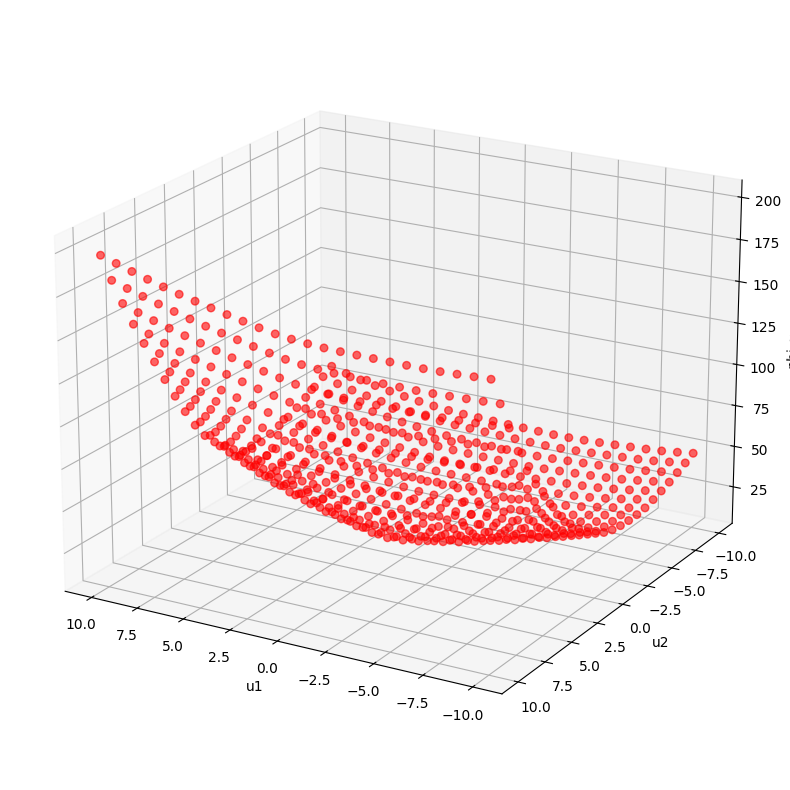

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
number_of_points_to_visualize = 1000

with torch.no_grad():
        ux = torch.linspace(-10, 10, steps=25, **device_and_dtype_specifications)
        uy = torch.linspace(-10, 10, steps=25, **device_and_dtype_specifications)
        U_meshgrid = torch.stack(torch.meshgrid(ux, uy, indexing='xy'), dim=-1).reshape(-1, 2)
        X_batch = X_tensor[51:52].repeat(U_meshgrid.shape[0], 1)
        potential_tensor = phi_network(X_batch, U_meshgrid)

potential = potential_tensor.detach().cpu().numpy()
U = U_meshgrid.detach().cpu().numpy()
scatter = ax.scatter(U[:, 0], U[:, 1], potential.squeeze(), color='red', marker='o', s=30, alpha=0.6)
ax.grid(True)

ax.view_init(elev=20, azim=120)
ax.set_xlabel('u1')
ax.set_ylabel('u2')
ax.set_zlabel('phi_u')

plt.show()

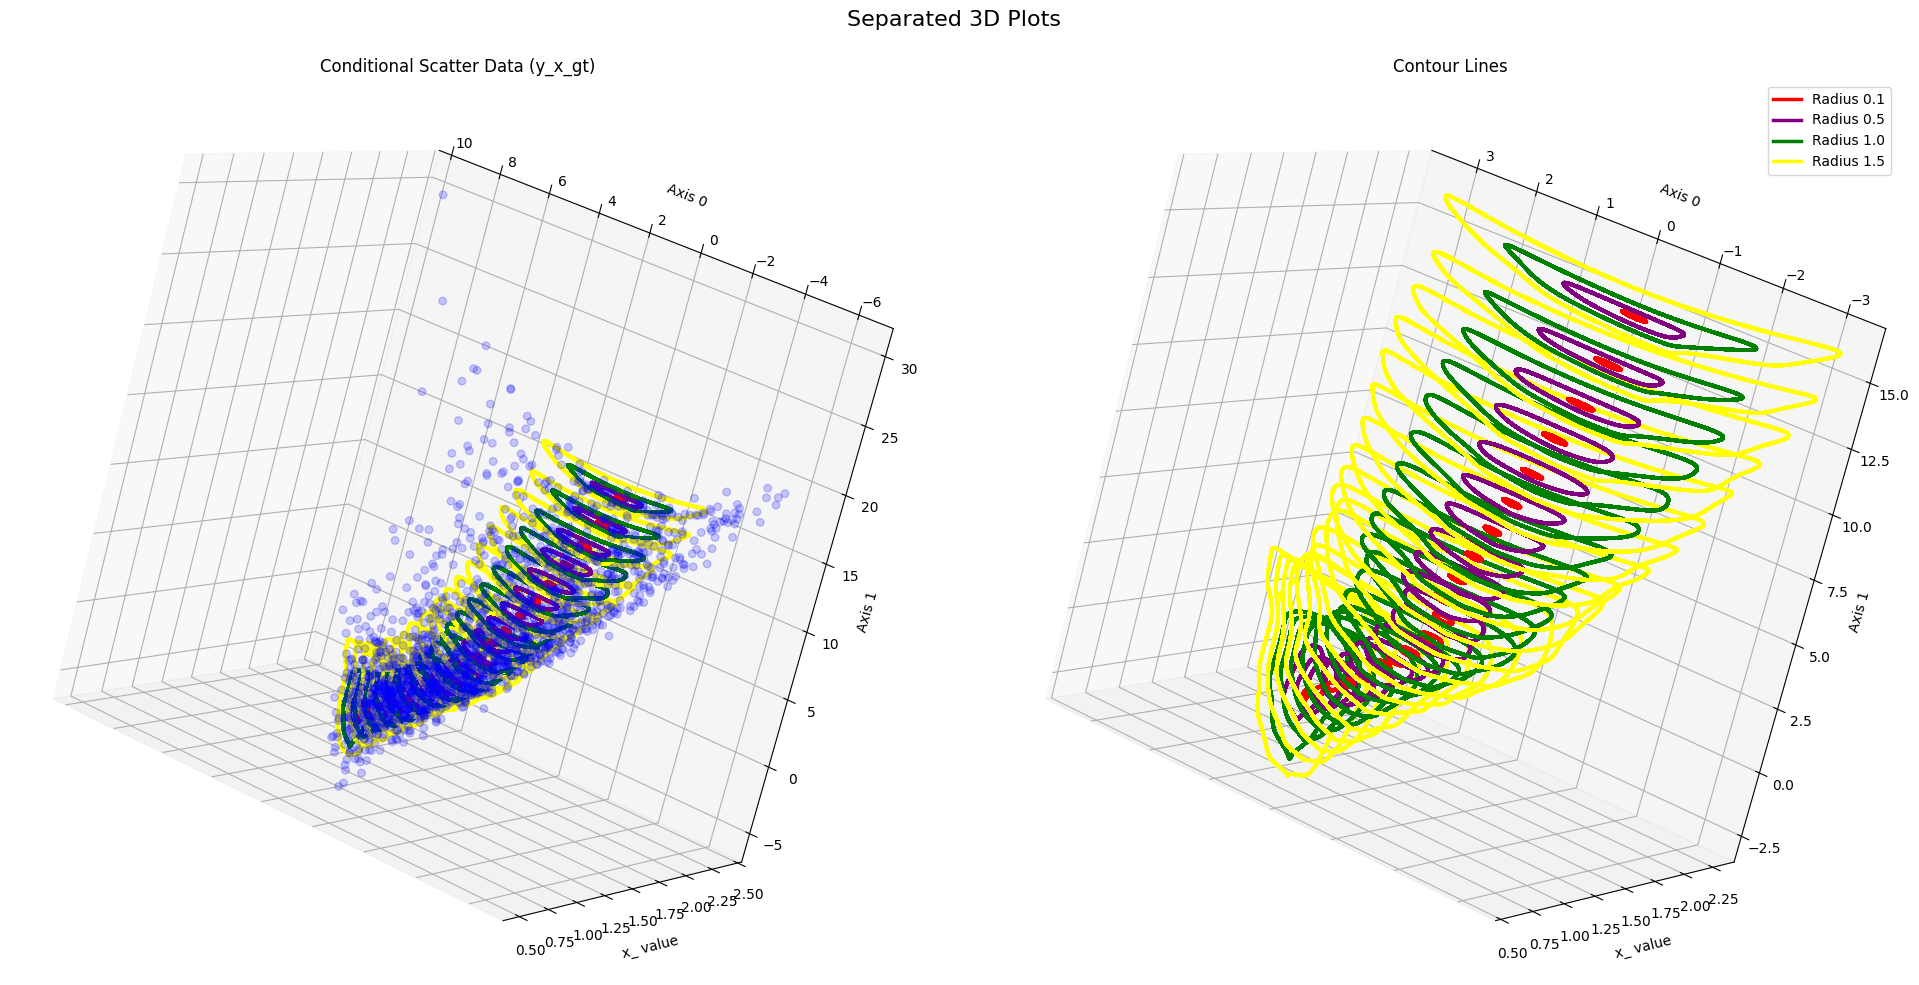

In [14]:
# Change to %matplotlib qt to have interactive plots
%matplotlib inline
import numpy as np
from data import create_conditional_x

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': '3d'})
fig.suptitle('Separated 3D Plots', fontsize=16)

ax1.set_title('Conditional Scatter Data (y_x_gt)')
ax1.set_xlabel('Axis 0')
ax1.set_ylabel('Axis 1')
ax1.set_zlabel('x_ value')

for x_ in range(50, 250, 10):
    x = np.array([x_ / 100])[:, None]

    # This section is now active for the first plot
    _, y_x_gt = create_conditional_x(n_points=100, x_value=x_/100)
    z_scatter = np.full(y_x_gt.shape[0], x)
    ax1.scatter(y_x_gt[:, 0], y_x_gt[:, 1], z_scatter, color='blue', marker='o', s=30, alpha=0.2)

ax1.view_init(elev=-55, azim=154, roll=-83)

ax2.set_title('Contour Lines')
ax2.set_xlabel('Axis 0')
ax2.set_ylabel('Axis 1')
ax2.set_zlabel('x_ value')

loop_start_value = 50
for x_ in range(loop_start_value, 250, 10):

    x = torch.tensor([x_ / 100], **device_and_dtype_specifications)[:, None]
    x = x.repeat(repeats=(100, 1))

    colors = ['red', 'purple', 'green', 'yellow']
    radii = [0.1, 0.5, 1., 1.5]
    for contour_radius, color in zip(radii, colors):
        pi_tensor = torch.linspace(-torch.pi, torch.pi, 100)
        u_tensor = torch.stack([
            contour_radius * torch.cos(pi_tensor),
            contour_radius * torch.sin(pi_tensor),
        ], dim=1)

        u_tensor = u_tensor.to(**device_and_dtype_specifications)
        u_tensor.requires_grad = True

        potential = phi_network(x, u_tensor)
        pushforward_of_u = torch.autograd.grad(potential.sum(), u_tensor)[0]

        z_line = x.detach().cpu().numpy()
        label = f'Radius {contour_radius}' if x_ == loop_start_value else ""
        ax1.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)
        ax2.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)

ax2.view_init(elev=-55, azim=154, roll=-83)
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()